# Task 3: Baseline Model Comparison (Neural Network)

In this notebook, you will train a simple Neural Network (MLP) to predict the `prior_hiring_decision` target variable. Compare its performance to the previous models.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

# Configuration: Toggle between weighted and unweighted training
USE_WEIGHTED = False  # Set to False for unweighted training

columns_to_drop = ["Hours_Per_Week", "Marital_Status", "Relationship"]
protected_characteristics = ["Sex", "Race", "Age", "Place_Of_Birth"]
target = 'prior_hiring_decision'

# Drop columns_to_drop
for df in [train_df, val_df, test_df]:
    df.drop(columns=columns_to_drop, inplace=True)

print(f"Training mode: {'WEIGHTED' if USE_WEIGHTED else 'UNWEIGHTED'}")
print("Training Shape:", train_df.shape)

Training mode: UNWEIGHTED
Training Shape: (30000, 10)


### **Equalized Odds**


In [5]:
def equalized_odds(data, pred_col='prediction', true_col='prior_hiring_decision'):
    """
    Compute equalized odds for binary race (white=1 vs non-white=anything else).
    TPR = P(pred=1 | true=1), FPR = P(pred=1 | true=0)
    """
    data = data.copy()
    data['_race_binary'] = (data['Race'] == 1).astype(int)
    
    tpr_rates = []
    fpr_rates = []
    
    for race in [0, 1]:  # 0=non-white, 1=white
        group_data = data[data['_race_binary'] == race]
        
        # Actual positives and negatives
        actual_positives = group_data[group_data[true_col] == 1]
        actual_negatives = group_data[group_data[true_col] == 0]
        
        # TPR: of actual positives, how many predicted positive?
        if len(actual_positives) > 0:
            tpr = actual_positives[pred_col].mean()
            tpr_rates.append(tpr)
        
        # FPR: of actual negatives, how many predicted positive?
        if len(actual_negatives) > 0:
            fpr = actual_negatives[pred_col].mean()
            fpr_rates.append(fpr)
    
    max_tpr, min_tpr = max(tpr_rates), min(tpr_rates)
    max_fpr, min_fpr = max(fpr_rates), min(fpr_rates)
    
    tpr_ratio = float('inf') if min_tpr == 0 else max_tpr / min_tpr
    fpr_ratio = float('inf') if min_fpr == 0 else max_fpr / min_fpr
    
    return max(tpr_ratio, fpr_ratio)

## 2. Preprocessing Fairness

In [6]:
def compute_group_weights(df, label_col):
    """
    Compute rebalancing weights for each (race_binary, label) combination.
    Returns a dictionary mapping (race_binary, label) -> weight.
    
    Weight formula: w = P(race) * P(label) / P(race, label)
    This makes race and label independent in the weighted distribution.
    """
    total = len(df)
    labels = df[label_col].unique()
    
    # Binary race: 1 = white, 0 = non-white
    race_binary = (df['Race'] == 1).astype(int)
    
    weights = {}
    for race in [0, 1]:
        race_count = (race_binary == race).sum()
        for label in labels:
            label_count = (df[label_col] == label).sum()
            intersection_count = ((race_binary == race) & (df[label_col] == label)).sum()
            
            if intersection_count > 0:
                # w = P(race) * P(label) / P(race, label)
                weight = (race_count * label_count) / (total * intersection_count)
            else:
                weight = 1.0
            
            weights[(race, int(label))] = float(weight)
    
    return weights


def get_sample_weights(df, group_weights, label_col):
    """
    Get per-sample weights array for use in loss function.
    """
    race_binary = (df['Race'] == 1).astype(int)
    sample_weights = [
        group_weights.get((race, int(label)), 1.0)
        for race, label in zip(race_binary, df[label_col])
    ]
    return np.array(sample_weights)


# Compute group weights from training data
group_weights = compute_group_weights(train_df, target)

print("Group Weights (applied to loss function):")
print("  Formula: w = P(race) * P(label) / P(race, label)")
print()
for (race, label), weight in sorted(group_weights.items()):
    race_name = "white" if race == 1 else "non-white"
    label_name = "hired" if label == 1 else "not hired"
    print(f"  {race_name}, {label_name}: {weight:.4f}")



Group Weights (applied to loss function):
  Formula: w = P(race) * P(label) / P(race, label)

  non-white, not hired: 0.8388
  non-white, hired: 1.2625
  white, not hired: 1.1321
  white, hired: 0.8879


## 3. Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim


In [8]:

# PyTorch classifier with sklearn-like API and sample weight support
class TorchBinaryMLP:
    def __init__(self,
                 hidden_layer_sizes=(64,),
                 alpha=0.0001,
                 learning_rate_init=0.001,
                 max_epochs=500,
                 random_state=42,
                 early_stopping=True,
                 batch_size=256,
                 patience=10,
                 device=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.early_stopping = early_stopping
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_ = None
        self.input_dim_ = None

    def _build_model(self, input_dim):
        layers = []
        prev = input_dim
        for h in self.hidden_layer_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.model_ = nn.Sequential(*layers).to(self.device)

    def fit(self, X, y, sample_weight=None):
        rng = np.random.RandomState(self.random_state)
        torch.manual_seed(self.random_state)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.random_state)

        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)
        
        # Handle sample weights
        if sample_weight is not None:
            sample_weight = np.asarray(sample_weight, dtype=np.float32).reshape(-1, 1)
        else:
            sample_weight = np.ones((len(X), 1), dtype=np.float32)

        self.input_dim_ = X.shape[1]
        self._build_model(self.input_dim_)

        optimizer = optim.Adam(self.model_.parameters(), lr=self.learning_rate_init, weight_decay=self.alpha)

        # internal validation split for early stopping
        if self.early_stopping:
            idx = rng.permutation(len(X))
            split = int(len(X) * 0.9)
            train_idx, val_idx = idx[:split], idx[split:]
            X_tr, y_tr, w_tr = X[train_idx], y[train_idx], sample_weight[train_idx]
            X_va, y_va, w_va = X[val_idx], y[val_idx], sample_weight[val_idx]
        else:
            X_tr, y_tr, w_tr = X, y, sample_weight
            X_va, y_va, w_va = None, None, None

        X_tr_t = torch.from_numpy(X_tr).to(self.device)
        y_tr_t = torch.from_numpy(y_tr).to(self.device)
        w_tr_t = torch.from_numpy(w_tr).to(self.device)

        best_val_loss = float('inf')
        best_state = None
        patience_left = self.patience

        for epoch in range(self.max_epochs):
            self.model_.train()
            # mini-batch training with sample weights
            perm = rng.permutation(len(X_tr_t))
            for i in range(0, len(X_tr_t), self.batch_size):
                batch_idx = perm[i:i+self.batch_size]
                xb = X_tr_t[batch_idx]
                yb = y_tr_t[batch_idx]
                wb = w_tr_t[batch_idx]
                
                optimizer.zero_grad()
                logits = self.model_(xb)
                # Weighted binary cross entropy
                loss = nn.functional.binary_cross_entropy_with_logits(logits, yb, weight=wb)
                loss.backward()
                optimizer.step()

            if self.early_stopping and X_va is not None:
                self.model_.eval()
                with torch.no_grad():
                    X_va_t = torch.from_numpy(X_va).to(self.device)
                    y_va_t = torch.from_numpy(y_va).to(self.device)
                    w_va_t = torch.from_numpy(w_va).to(self.device)
                    val_logits = self.model_(X_va_t)
                    val_loss = nn.functional.binary_cross_entropy_with_logits(val_logits, y_va_t, weight=w_va_t).item()

                if val_loss < best_val_loss - 1e-5:
                    best_val_loss = val_loss
                    best_state = {k: v.clone() for k, v in self.model_.state_dict().items()}
                    patience_left = self.patience
                else:
                    patience_left -= 1
                    if patience_left <= 0:
                        break

        if best_state is not None:
            self.model_.load_state_dict(best_state)

        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        self.model_.eval()
        with torch.no_grad():
            X_t = torch.from_numpy(X).to(self.device)
            logits = self.model_(X_t)
            probs_pos = torch.sigmoid(logits).cpu().numpy().ravel()
        probs_neg = 1.0 - probs_pos
        return np.column_stack([probs_neg, probs_pos])

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        y = np.asarray(y)
        return (y_pred == y).mean()

    def get_params(self, deep=True):
        return {
            'hidden_layer_sizes': self.hidden_layer_sizes,
            'alpha': self.alpha,
            'learning_rate_init': self.learning_rate_init,
            'max_epochs': self.max_epochs,
            'random_state': self.random_state,
            'early_stopping': self.early_stopping,
            'batch_size': self.batch_size,
            'patience': self.patience,
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self


In [9]:
# 1. Prepare sample weights
if USE_WEIGHTED:
    sample_weights = get_sample_weights(train_df, group_weights, target)
else:
    sample_weights = None

# 2. Define features and split
cols_to_exclude = protected_characteristics + [target]
features = [col for col in train_df.columns if col not in cols_to_exclude]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Features: {features}")
print(f"X_train shape: {X_train.shape}")

# 3. Preprocessing pipeline (same as decision tree and logistic regression)
categorical_cols = [col for col in ['Workclass', 'Education', 'Occupation'] if col in features]
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# 4. Simple grid search with max 2 configs
param_configs = [
    {'hidden_layer_sizes': (64,), 'alpha': 0.001, 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (64, 32), 'alpha': 0.001, 'learning_rate_init': 0.001},
]

print(f"\nTraining with {'SAMPLE WEIGHTS' if USE_WEIGHTED else 'NO WEIGHTS'}...")
print(f"Testing {len(param_configs)} configurations...\n")

best_score = 0.0
best_params = {}
best_clf = None

for params in param_configs:
    clf = TorchBinaryMLP(
        **params,
        max_epochs=500,
        random_state=42,
        early_stopping=True
    )
    clf.fit(X_train_processed, y_train, sample_weight=sample_weights)
    score = clf.score(X_val_processed, y_val)
    
    print(f"  Config {params['hidden_layer_sizes']}: val_acc={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_params = params
        best_clf = clf

print(f"\nBest params: {best_params}")
print(f"Best validation accuracy: {best_score:.4f}")

Features: ['Workclass', 'Education', 'Occupation', 'interview_score', 'cv_assessment_score']
X_train shape: (30000, 5)

Training with NO WEIGHTS...
Testing 2 configurations...

  Config (64,): val_acc=0.7346
  Config (64, 32): val_acc=0.7371

Best params: {'hidden_layer_sizes': (64, 32), 'alpha': 0.001, 'learning_rate_init': 0.001}
Best validation accuracy: 0.7371


## 4. Evaluation Metrics

In [10]:
y_pred = best_clf.predict(X_test_processed)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7322
Confusion Matrix:
[[3767 1463]
 [1215 3555]]


## 5. Fairness Metric Implementation

In [11]:
val_with_preds = val_df.copy()
val_with_preds['prediction'] = best_clf.predict(X_val_processed)

# Compute equalized odds for binary race (white vs non-white)
eo_ratio = equalized_odds(val_with_preds, pred_col='prediction', true_col=target)

# Get detailed TPR/FPR by group
val_with_preds['_race_binary'] = (val_with_preds['Race'] == 1).astype(int)
results = {}
for race in [0, 1]:
    group_data = val_with_preds[val_with_preds['_race_binary'] == race]
    
    # Actual positives and negatives (based on true label)
    actual_positives = group_data[group_data[target] == 1]
    actual_negatives = group_data[group_data[target] == 0]
    
    race_name = "white" if race == 1 else "non-white"
    results[race_name] = {
        'tpr': float(actual_positives['prediction'].mean()) if len(actual_positives) > 0 else None,
        'fpr': float(actual_negatives['prediction'].mean()) if len(actual_negatives) > 0 else None,
        'count': len(group_data)
    }

print("Fairness Metrics (Neural Network) - Binary Race:")
print(f"\nEqualized Odds Ratio: {eo_ratio:.4f}")
print("\nBy Group:")
for group, metrics in results.items():
    print(f"  {group}: TPR={metrics['tpr']:.4f}, FPR={metrics['fpr']:.4f}, Count={metrics['count']}")

Fairness Metrics (Neural Network) - Binary Race:

Equalized Odds Ratio: 1.9852

By Group:
  non-white: TPR=0.6242, FPR=0.1663, Count=3756
  white: TPR=0.7801, FPR=0.3301, Count=6244


## 6. ROC Curve Analysis

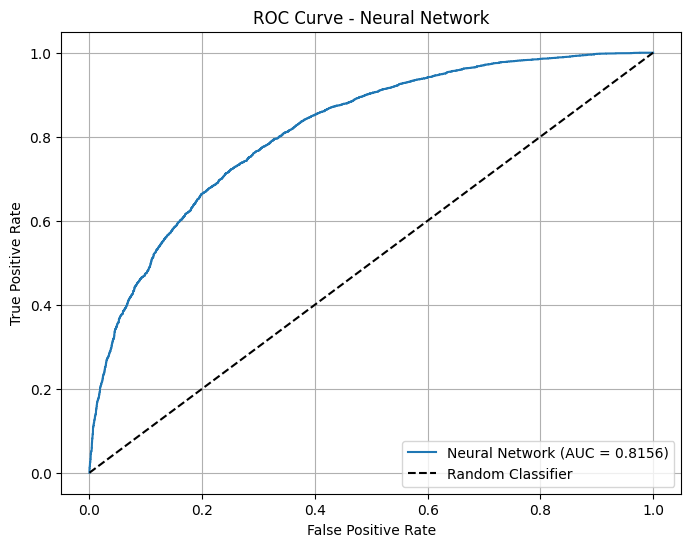

AUC Score: 0.8156


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = best_clf.predict_proba(X_test_processed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc='lower right')
plt.grid(True)
weight = "weighted" if USE_WEIGHTED else "unweighted"
plt.savefig(f'../data/nn_roc_{weight}.png')
plt.show()


print(f"AUC Score: {auc_score:.4f}")

## 7. Adjusted Equalized Odds

In [21]:
def adjusted_equalized_odds(data, y_true_col, y_proba, thresholds):
    """
    Calculate equalized odds using group-specific classification thresholds.
    Uses binary race: white (Race==1) vs non-white (Race!=1).
    
    Args:
        data: DataFrame with Race column and true labels
        y_true_col: Name of true label column
        y_proba: Array of predicted probabilities
        thresholds: Dict mapping race_binary (0 or 1) to classification threshold
                    e.g., {0: 0.4, 1: 0.6} means non-white uses 0.4, white uses 0.6
    
    Returns:
        Dict with TPR/FPR per group and equalized odds ratio
    """
    data = data.copy()
    data['y_proba'] = y_proba
    data['_race_binary'] = (data['Race'] == 1).astype(int)
    
    # Apply group-specific thresholds
    data['adjusted_pred'] = data.apply(
        lambda row: 1 if row['y_proba'] >= thresholds.get(row['_race_binary'], 0.5) else 0,
        axis=1
    )
    
    tpr_rates = []
    fpr_rates = []
    results = {}
    
    for race in [0, 1]:  # 0=non-white, 1=white
        group_data = data[data['_race_binary'] == race]
        actual_positives = group_data[group_data[y_true_col] == 1]
        actual_negatives = group_data[group_data[y_true_col] == 0]
        
        tpr = actual_positives['adjusted_pred'].mean() if len(actual_positives) > 0 else 0
        fpr = actual_negatives['adjusted_pred'].mean() if len(actual_negatives) > 0 else 0
        
        tpr_rates.append(tpr)
        fpr_rates.append(fpr)
        
        race_name = "white" if race == 1 else "non-white"
        results[race_name] = {
            'tpr': float(tpr),
            'fpr': float(fpr),
            'threshold': float(thresholds.get(race, 0.5)),
            'count': int(len(group_data))
        }
    
    max_tpr, min_tpr = max(tpr_rates), min(tpr_rates)
    max_fpr, min_fpr = max(fpr_rates), min(fpr_rates)
    
    tpr_ratio = max_tpr / min_tpr if min_tpr > 0 else float('inf')
    fpr_ratio = max_fpr / min_fpr if min_fpr > 0 else float('inf')
    
    results['tpr_ratio'] = float(tpr_ratio)
    results['fpr_ratio'] = float(fpr_ratio)
    results['equalized_odds_ratio'] = float(max(tpr_ratio, fpr_ratio))
    
    return results

## 8. Equalized Adjusted Odds 

In [22]:
# Example: Apply adjusted equalized odds with group-specific thresholds
# These thresholds can be tuned to achieve fairer outcomes across groups

y_val_proba = best_clf.predict_proba(X_val_processed)[:, 1]

# Example thresholds (can be tuned based on desired fairness-accuracy tradeoff)
thresholds = {
    0: 0.45,  # non-white threshold
    1: 0.55,  # white threshold
}

adjusted_results = adjusted_equalized_odds(
    val_df, 
    y_true_col=target, 
    y_proba=y_val_proba, 
    thresholds=thresholds
)

# Calculate accuracy with adjusted thresholds
val_with_adjusted = val_df.copy()
val_with_adjusted['_race_binary'] = (val_with_adjusted['Race'] == 1).astype(int)
val_with_adjusted['adjusted_pred'] = [
    1 if prob >= thresholds[race] else 0 
    for prob, race in zip(y_val_proba, val_with_adjusted['_race_binary'])
]
adjusted_accuracy = accuracy_score(val_with_adjusted[target], val_with_adjusted['adjusted_pred'])

print("Adjusted Equalized Odds Results:")
print(f"  Thresholds: non-white={thresholds[0]}, white={thresholds[1]}")
print(f"\n  Accuracy: {adjusted_accuracy:.4f}")
print()
for group in ['non-white', 'white']:
    metrics = adjusted_results[group]
    print(f"  {group}: TPR={metrics['tpr']:.4f}, FPR={metrics['fpr']:.4f}, Count={metrics['count']}")
print()
print(f"  TPR Ratio: {adjusted_results['tpr_ratio']:.4f}")
print(f"  FPR Ratio: {adjusted_results['fpr_ratio']:.4f}")
print(f"  Equalized Odds Ratio: {adjusted_results['equalized_odds_ratio']:.4f}")

Adjusted Equalized Odds Results:
  Thresholds: non-white=0.45, white=0.55

  Accuracy: 0.7379

  non-white: TPR=0.6825, FPR=0.2040, Count=3756
  white: TPR=0.7362, FPR=0.2774, Count=6244

  TPR Ratio: 1.0787
  FPR Ratio: 1.3595
  Equalized Odds Ratio: 1.3595
